# Super Bowl Ad Brief Generator

- Grab your OpenAI API Key ([API Key Page](https://platform.openai.com/api-keys))
- Add it to the secrets from the side menu under `OPENAI_API_KEY`
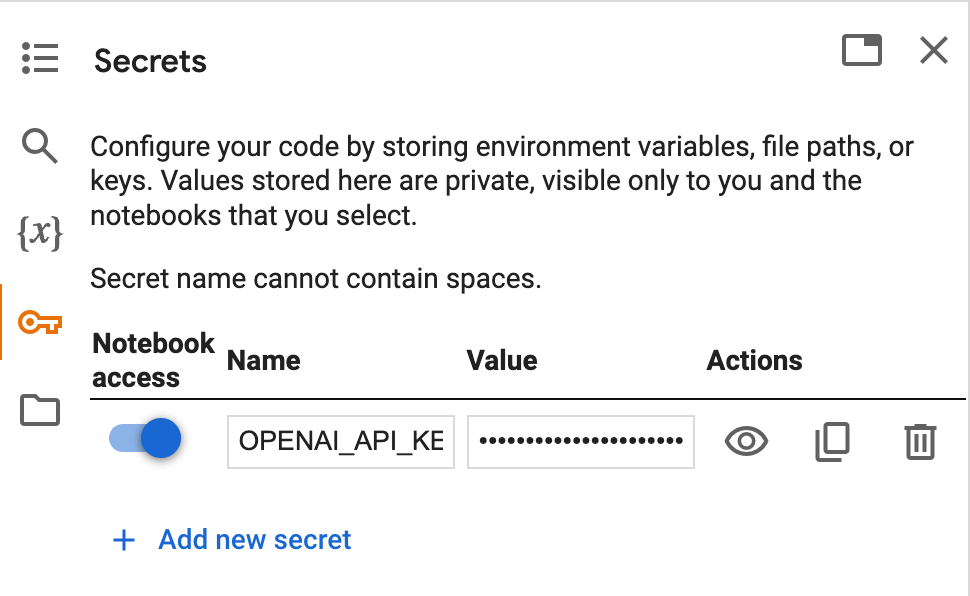
- Follow Instructions on next sections


## 1. Setup: Install Dependencies and Setup Utility Classes & Methods

In [35]:
!pip install langchain langchain-openai

In [36]:
# Imports
import os
from typing import List, Optional
from tqdm.autonotebook import tqdm
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from google.colab import userdata
from IPython.display import display, HTML

In [37]:
# Set API Key Env Variable
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [38]:
# Data Classes

class IdeaDescription(BaseModel):
    assumptions: List[str] = Field(
        description="Assumptions made about the ad request that are not explicitly stated in the brief")
    purpose: str = Field(
        description="The purpose of the ad")
    target_audience: List[str] = Field(
        description="List of the target audience for the ad")
    key_message: str = Field(
        description="Key message or messages that the ad should convey")
    desired_action: str = Field(
        description="The desired action that the audience should take after watching the ad")


class CreativeBrief(BaseModel):
    objective: str = Field(description="Main objective of the ad")
    audience: str = Field(description="The target audience for the ad")
    key_messages: List[str] = Field(
        description="Key messages that the ad should convey")
    duration: int = Field(description="Duration in seconds of the ad")
    tone: str = Field(description="The tone of the ad")
    style: str = Field(description="The style of the ad")
    requirements: List[str] = Field(description="Any specific requirements for the ad to follow")


class CreativeConcept(BaseModel):
    title: str = Field(description="What is the title or name of the ad concept?")
    description: str = Field(description="What is the concept of the ad? What is the story or idea behind the video?")


class CreativeConcepts(BaseModel):
    concepts: List[CreativeConcept] = Field(
        description="List of concepts for the ad")


# Script Classes
class Dialogue(BaseModel):
    character: str = Field(description="The character speaking the line, could be a person or a voiceover")
    line: str = Field(description="The dialogue line")


class Scene(BaseModel):
    title: Optional[str] = Field(description="The title of the scene")
    setting: Optional[str] = Field(description="The setting of the scene")
    description: Optional[str] = Field(description="The description of the scene")
    dialogues: Optional[List[Dialogue]] = Field(description="List of dialogues in the scene")


class Script(BaseModel):
    scenes: List[Scene] = Field(description="List of scenes in the script")


# Storyboard Classes
class StoryboardFrame(BaseModel):
    scene_number: int = Field(description="The number of the scene")
    description: str = Field(
        description="Direct description of a single frame in the scene without references to the scene, focusing only on describing the scene visually. This represents a single panel in the storyboard and should be detailed enough to be used as a prompt for generative AI to create the storyboard panel")
    image: str = Field(default='',
                       description="Ignore this field, it is used to store the generated images for the storyboard frame")


class Storyboard(BaseModel):
    frames: List[StoryboardFrame] = Field(
        description="List of frames in the storyboard, each frame represents a single panel in the storyboard")

In [39]:
def generate_ad_idea_description(model: ChatOpenAI, brief: str) -> IdeaDescription:
    """Generate an idea description for a Super Bowl ad based on the brief."""
    parser = PydanticOutputParser(pydantic_object=IdeaDescription)

    prompt = PromptTemplate(
        template="""You are a creative account manager and you have been tasked with taking a one sentence brief of the subject of the ad and generate a detailed idea description that will be handed to the creative director, make sure to cover all ground and set the creative team up for successes.

        {format_instructions}

        The video is for: {input}""",
        input_variables=["input"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    idea_description = chain.invoke({"input": brief})

    return idea_description


def generate_creative_brief(model: ChatOpenAI, idea_description: IdeaDescription) -> CreativeBrief:
    """Generate a creative brief based on the idea description."""
    parser = PydanticOutputParser(pydantic_object=CreativeBrief)

    prompt = PromptTemplate(
        template="""You are a creative director and you have been tasked with creating a 30 seconds video ad for the super bowl. Based on the idea description provided below by the account manager, generative a comprehensive creative brief for a compelling ad.

        {format_instructions}

        Idea Description:
        - Purpose: {purpose}
        - Target Audience: {target_audience}
        - Key Message: {key_message}
        - Desired Action: {desired_action}""",
        input_variables=["purpose", "target_audience", "key_message", "desired_action"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    return chain.invoke({
        "purpose": idea_description.purpose,
        "target_audience": idea_description.target_audience,
        "key_message": idea_description.key_message,
        "desired_action": idea_description.desired_action
    })


def generate_concepts(model: ChatOpenAI, creative_brief: CreativeBrief) -> List[CreativeConcept]:
    # Step 3: Generate a set of concepts for the video based on the creative brief
    parser = PydanticOutputParser(pydantic_object=CreativeConcepts)

    prompt = PromptTemplate(
        template="""You are a creative director and you have been tasked with creating a video ad. Based on the creative brief provided below, generate 4 creative, unique, and compelling creative concepts.

        {format_instructions}

        Creative Brief:
        - Objective: {objective}
        - Audience: {audience}
        - Duration: {duration} seconds
        - Key Messages: {key_messages}
        - Tone: {tone}
        - Style: {style}
        - Requirements: {requirements}
        """,
        input_variables=["objective", "audience", "duration", "key_messages", "tone", "style", "requirements"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    return chain.invoke({
        "objective": creative_brief.objective,
        "audience": creative_brief.audience,
        "duration": creative_brief.duration,
        "key_messages": creative_brief.key_messages,
        "tone": creative_brief.tone,
        "style": creative_brief.style,
        "requirements": creative_brief.requirements
    }).concepts


def generate_script(model: ChatOpenAI, creative_brief: CreativeBrief, concept: CreativeConcept) -> Script:
    parser = PydanticOutputParser(pydantic_object=Script)

    prompt = PromptTemplate(
        template="""You are a screenwriter and you have been tasked with creating a script for a video ad. Based on the concept and creative brief provided below, generate a unique and engaging script with a compelling story, when referencing the product or service, describe how it looks like in detail.

        {format_instructions}

        Concept:
        - Title: {title}
        - Description: {description}

        Creative Brief:
        - Objective: {objective}
        - Audience: {audience}
        - Duration: {duration} seconds
        - Key Messages: {key_messages}
        - Tone: {tone}
        - Style: {style}
        - Requirements: {requirements}
        """,
        input_variables=["title", "description", "objective", "audience", 'duration', "key_messages", "tone", "style",
                         "requirements"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    return chain.invoke({
        "title": concept.title,
        "description": concept.description,
        "objective": creative_brief.objective,
        "audience": creative_brief.audience,
        "duration": creative_brief.duration,
        "key_messages": creative_brief.key_messages,
        "tone": creative_brief.tone,
        "style": creative_brief.style,
        "requirements": creative_brief.requirements
    })

def generate_storyboard_with_images(model: ChatOpenAI, dalle: DallEAPIWrapper, script: Script) -> Storyboard:
    storyboard = generate_storyboard(model, script)
    storyboard = generate_storyboard_images(dalle, storyboard)
    return storyboard

def generate_storyboard(model: ChatOpenAI, script: Script) -> Storyboard:
    parser = PydanticOutputParser(pydantic_object=Storyboard)

    prompt = PromptTemplate(
        template="""You are a storyboard artist and you have been tasked with creating a storyboard for a video ad. Based on the script provided below between triple backticks, generate a list of detailed storyboard panels. Each panel should be a single square storyboard focus only on the visual elements and do not reference the scenes or ad.

        {format_instructions}

        Script in JSON format:
        ```
        {script}
        ```
        """,
        input_variables=["script"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    return chain.invoke({
        "script": script.dict()
    })


def generate_storyboard_images(dalle: DallEAPIWrapper, storyboard: Storyboard) -> Storyboard:
    """Generate images for the storyboard frames using DALL-E."""
    for scene in tqdm(storyboard.frames):
        prompt = f"{scene.description} fullscreen detailed sketch outline style with no borders or margins."
        image = dalle.run(prompt)
        scene.image = image

    return storyboard

## 2. Generate Creative Brief based on User Input

In [40]:
# @title Enter Brief Product or Service Description { vertical-output: true, display-mode: "form" }

ad_idea = "dog food that makes dogs able to talk" # @param {type:"string"}
llm = "gpt-4-turbo-preview" # @param {type:"string"}
image_model = "dall-e-3" # @param {type:"string"}

temprature = 1 if '4' in llm else 0
model = ChatOpenAI(model_name=llm, temperature=temprature)
dalle = DallEAPIWrapper(model=image_model)

idea_description = generate_ad_idea_description(model, ad_idea)

creative_brief = generate_creative_brief(model, idea_description)

print("Creative Brief")
print("Objective:", creative_brief.objective)
print("Audience:", creative_brief.audience)
print("Duration:", creative_brief.duration, "seconds")
print("Key Messages:")
for message in creative_brief.key_messages:
    print(f'- {message}')
print("Tone:", creative_brief.tone)
print("Style:", creative_brief.style)
print("Requirements:")
for requirement in creative_brief.requirements:
    print(f'- {requirement}')

Creative Brief
Objective: To highlight the unique benefit of the dog food that facilitates a deeper connection between dogs and their owners, driving up interest and encouraging purchases.
Audience: Dog owners of all ages, potential pet owners considering adopting a dog, and veterinary professionals interested in innovative pet care products
Duration: 30 seconds
Key Messages:
- Transform your relationship with your dog like never before.
- Understand your dog's needs, joys, and fears with unparalleled clarity.
- Experience a new level of companionship with your pet through our revolutionary dog food.
Tone: Inspirational, warm, engaging
Style: Narrative story-telling combined with vibrant visuals of dogs and their owners experiencing joy and understanding
Requirements:
- The ad must include real-life testimonials or reenacted scenarios showcasing the positive change in dogs' behaviors and their relationship with their owners post consuming the dog food.
- Include a clear call-to-action 

## 3. Generate Concepts

Generate and select a creative concept

In [41]:
# @title Generate Concept { vertical-output: true, display-mode: "form" }

creative_concepts = generate_concepts(model, creative_brief)

for index, concept in enumerate(creative_concepts):
  print(f'Concept {index + 1}: {concept.title}')
  print(concept.description)

Concept 1: The Whisperer
The ad starts with a montage of misunderstood dogs - a yapping Chihuahua, a distant German Shepherd, and a hyperactive Labrador, all struggling to communicate with their despondent owners. Cut to these dogs now calm, joyful, and in sync with their owners after transitioning to the revolutionary dog food. Each pair shares a unique activity that strengthens their bond: reading together (now understanding each other's silence), running in harmony, and playing catch with precision. A voiceover recites the key messages as these heartwarming scenes unfold, ending with a call-to-action. The last scene shows a diverse group of dogs and owners, all together, portraying unity and understanding achieved through the product.
Concept 2: A Day in the Life
This concept focuses on a single day, from sunrise to sunset, showing the life of a dog and its owner before and after consuming the innovative dog food. In the 'Before' segment, the day starts with confusion and misunderst

## 4. Select a Concept to Generate Script

In [42]:
# @title Select a Concept to Generate Script { vertical-output: true, display-mode: "form" }

concept_number = 2 # @param {type:"integer"}

if concept_number >= 1 and concept_number <= len(creative_concepts):
  selected_concept = creative_concepts[concept_number - 1]

  script = generate_script(model, creative_brief, selected_concept)

  for index, scene in enumerate(script.scenes):
    print("-"*20)
    print(f'Scene {index + 1}: {scene.title}')
    print(f'Setting: {scene.setting}')
    print(f'Description: {scene.description}')
    if scene.dialogues:
        print('Dialogues:')
        for dialogue in scene.dialogues:
            print(f'- {dialogue.character}: {dialogue.line}')
else:
  print(f"Number out of range, select number between 1 and {len(creative_concepts)} ")

--------------------
Scene 1: Morning Frustration - Before
Setting: Suburban home, early morning
Description: A dimly lit kitchen scene where an owner is hurriedly attempting to communicate with their dog. The dog seems disinterested and misunderstands the commands.
Dialogues:
- Owner: Buddy, eat your food, we need to go for a walk!
- Voiceover: Sometimes, no matter how hard we try, our messages just don't get through.
--------------------
Scene 2: Testimonial Cut - Before
Setting: White backdrop
Description: A series of quick cuts featuring different dog owners reflecting on their challenging experiences.
Dialogues:
- Owner 1: It was like we were speaking different languages.
- Owner 2: I just couldn't understand why she wouldn't listen.
--------------------
Scene 3: Transformation Introduction
Setting: Cozy living room
Description: A packaged bag of the innovative dog food is introduced. The bag is sleek, with vibrant colors and a clear, engaging photo of a dog and owner sharing a jo

## 5. Generate Storyboard (Warning: Expensive!)
Also takes a while

In [44]:
# @title Generate Storyboard { vertical-output: true, display-mode: "form" }

storyboard_with_images = generate_storyboard_with_images(model, dalle, script)

image_frames = [frame for frame in storyboard_with_images.frames if frame.image]

# Create the HTML content for displaying the images with captions
html_content = "<div>"
for frame in image_frames:
    html_content += f'<img src="{frame.image}" style="max-width: 50%;"><br><p>{frame.description}</p>'
html_content += "</div>"

display(HTML(html_content))

  0%|          | 0/9 [00:00<?, ?it/s]